In [1]:
%matplotlib notebook 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import cv2
import random
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pretrainedmodels.utils as utils
import torch
import torch.optim as optim
from apex import amp
from easydict import EasyDict
from numpy.random import choice, seed
from PIL import Image
from pretrainedmodels import xception
from torch import nn
from torch import from_numpy
from torch.utils.data import Dataset, SequentialSampler
from torchvision import transforms as tt
from torchvision.transforms.functional import to_tensor
from tqdm import tqdm_notebook as tqdm
# from unet.unet_model import UNet
from segmentation_models_pytorch import Unet
from custom_pytorch import custom_layers
from custom_pytorch.custom_models import SamplingSegmentationV4 as SamplingSegmentation
from custom_pytorch.custom_samplers import SubsetRandomSampler
from custom_pytorch.custom_schedulers import AdaptiveCyclicCosineAnnealing
from custom_pytorch.custom_losses.dice import BCEAndDiceLoss
from custom_pytorch.metrics import DiceCoeff

from custom_pytorch.custom_logs.segmentation import Logger
from custom_pytorch.custom_visualizations.segmentation import Visualizer
from custom_pytorch.custom_utils import get_model_name
from custom_pytorch.optimizers.adabound import AdaBound
from torchcontrib.optim import SWA

# dice_loss = GeneralizedDiceLoss()
import PyQt5
sys.path.insert(0, '../')
from shared import *
from config import CONFIG
import fastai

Training folder data size: 10712
Testing folder data size: 1377


In [4]:
# net = SamplingSegmentation(3, 1, CONFIG.net_params.depth, CONFIG.net_params.resolution).cuda()
net = SamplingSegmentation(3, 1, CONFIG.net_params.depth).cuda()
# net = NeuralNet().cuda()
optimizer = optim.Adam(
    net.parameters(), lr=CONFIG.lr, weight_decay=CONFIG.weight_decay)
# optimizer = SWA(base_opt, swa_start=10, swa_freq=5, swa_lr=0.05)
# net, optimizer = amp.initialize(net, optimizer, opt_level="O1")
# net, optimizer
if CONFIG.warm_start_from:
    loaded = torch.load(os.path.join(MODEL_SAVE_DIR, CONFIG.warm_start_from))
    loaded_epoch = loaded['epoch'] + 1
    net.load_state_dict(loaded['model_state_dict'], strict=False)
else:
    loaded_epoch = 0

In [5]:
# pixels_weights = from_numpy(train_dataset.compute_pixels_weights(train_indices)).float().cuda()

        
loss_function = lambda x, y: BCEAndDiceLoss()(x, y, dice_loss_kwargs={'wrt_batch': False})#pos_weight=pixels_weights)
# loss_function = nn.BCEWithLogitsLoss()

In [6]:
dice_coeff = DiceCoeff()
trainer = Trainer(net, loss_function, dice_coeff, True, True)
tester = Tester(net, True, True)

<IPython.core.display.Javascript object>


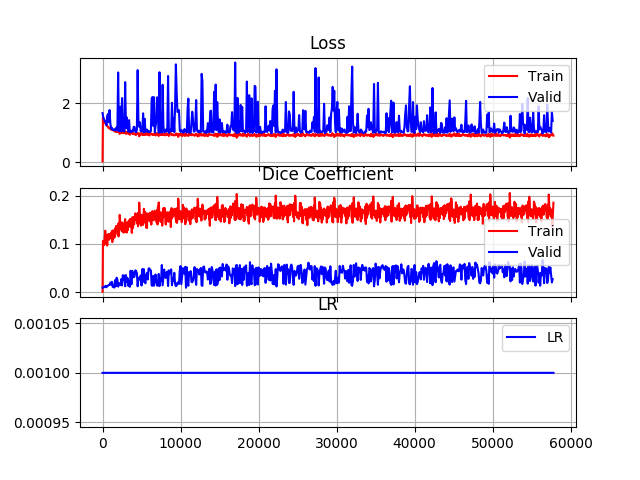

<IPython.core.display.Javascript object>


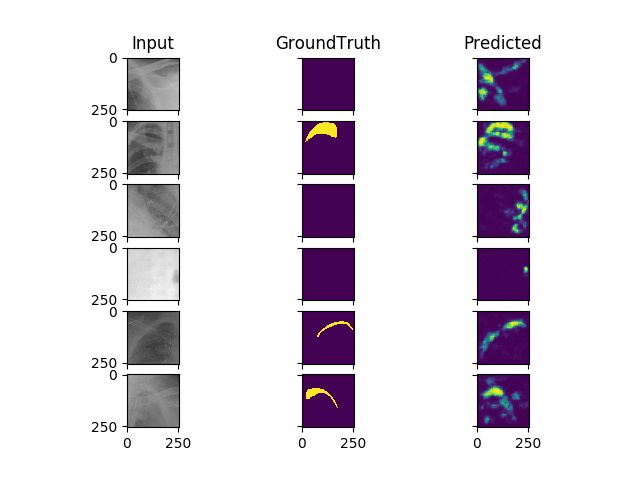

In [ ]:
net.train()

epochs_num = 60
# scheduler = AdaptiveCyclicCosineAnnealing(CONFIG.lr,  optimizer, 200, CONFIG.train_batches_num, snapshots_num=8)


train_losses = {}
train_coeffs = {}
valid_losses = {}
valid_coeffs = {}
step = 0
run_validation_every_n_steps = 100

examples_savedir = os.path.join(LOGS_SAVE_DIR, 'visual')
try:
    os.makedirs(examples_savedir)
except OSError:
    pass

    
VISUAL_EXAMPLES_EVERY = 50
TRAIN_PLOT_EVERY = 50
partial_loss = 0
partial_coeff = 0
loss = None
net.train()
visualizer = Visualizer(CONFIG, metric_used='Dice Coefficient', include_lr=True, examples_savedir=examples_savedir)
logger = Logger(CONFIG, metric_used='Dice Coefficient', save_dir=LOGS_SAVE_DIR)
for epoch in range(epochs_num):
    epoch = epoch + loaded_epoch
    iterator = tqdm(trainer.train_loader, desc=f'Epoch {epoch + 1}')
    train_loss = 0
    valid_loss = None
    cnt = 0
    for batch in iterator:
        cnt += 1
        optimizer.zero_grad()
        out, loss, coeff = trainer.train_step(batch)
#         loss = train_d_loss
#         with amp.scale_loss(loss, optimizer) as scaled_loss:
#             scaled_loss.backward()
        optimizer.step()
#         scheduler.step(loss, net, train_d_loss.cpu().data.numpy(), epoch)
        train_d_coeff = coeff.cpu().data.numpy()
        train_losses[step] = loss.cpu().data.numpy()
        train_coeffs[step] = train_d_coeff
        
        train_loss += train_losses[step]
        partial_loss += train_losses[step]
        partial_coeff += train_d_coeff
#         update_lr_plot(step, lr=scheduler.lr)
        logger.update(step, train_losses[step], train_coeffs[step])
        visualizer.update_lr(step, lr=CONFIG.lr)
        if step % TRAIN_PLOT_EVERY == 0:
            visualizer.update_loss_and_metric(step, partial_loss/TRAIN_PLOT_EVERY, partial_coeff/TRAIN_PLOT_EVERY)
            partial_loss = 0
            partial_coeff = 0
        if step % VISUAL_EXAMPLES_EVERY == 0:
            img = np.rollaxis(out[0].cpu().data.numpy(), 1, 4)
            visualizer.update_examples_plot(step,
                                img,
                                out[1].cpu().data.numpy(),
                                out[2].cpu().data.numpy())

        if cnt == 0 or step % run_validation_every_n_steps == 0:
            valid_loss = 0
            v_cnt = 0
            valid_d_coeff = 0
            with torch.no_grad():
               
                for v_batch in tqdm(trainer.valid_loader, desc='Performing validation'):
                    v_cnt += 1
                    out, valid_l, coeff = trainer.valid_step(v_batch)
                    valid_d_coeff += coeff.cpu().data.numpy()
                    valid_loss += valid_l.cpu().data.numpy()
            valid_d_coeff = valid_d_coeff / v_cnt
            valid_loss = valid_loss / v_cnt
            valid_losses[step] = valid_loss
            valid_coeffs[step] = valid_d_coeff
            logger.update(step, valid_loss, valid_d_coeff, True)
            visualizer.update_loss_and_metric(step, valid_loss, valid_d_coeff, True)
        
        iterator.set_description(
            'Epoch: %d \n TLoss: %.3f, VLoss: %s'%(
                epoch + 1, train_loss / cnt,
                'None' if valid_loss is None else '%.3f'%(valid_loss)))
        
        step += 1
    train_loss = train_loss / cnt
    
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            't_losses': train_losses,
            'v_losses': valid_losses,
            'config':CONFIG}, os.path.join(MODEL_SAVE_DIR, get_model_name(CONFIG, epoch, train_loss, valid_loss))
            )
    torch.cuda.empty_cache()
